<a href="https://colab.research.google.com/github/abdulsamadkhan/Reasoning/blob/main/Fine_tune_a_model_with_GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies


In [ ]:
!pip install unsloth vllm
!pip install --upgrade pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.7/192.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/2

Now we’ll import the necessary libraries.



In [ ]:
import torch
import re
from datasets import load_dataset
from trl import GRPOConfig, GRPOTrainer
from unsloth import FastLanguageModel


INFO 04-06 10:53:11 [__init__.py:239] Automatically detected platform cuda.


<ipython-input-1-a401aea3caf7>:5: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


#Load the dataset
Now, let’s load the dataset. In this case, we’ll use the mlabonne/smoltldr dataset, which contains a list of short stories.

In [ ]:
dataset = load_dataset("mlabonne/smoltldr")
print(dataset)

README.md:   0%|          | 0.00/981 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.44M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 200
    })
})


In [ ]:
dataset['train'][10]['prompt']

'SUBREDDIT: r/relationships\n\nTITLE: How do I (F19) take the next step with crush (M19)?\n\nPOST: I posted here a couple of days ago because i wasnt sure if this guy liked me. Honestly im still not sure but ive been flirting more with him and said he looks cute in certain snaps etc. We dont see eachother a lot irl, but when we do, how do I take the next step. When we meet there isnt any touch except hug when we meet and when we say goodbye. We are both shy. I think he knows that I like him now and hes not backing off so what do i do when we meet in person? (new to dating)\n\nTL;DR:'

#Load model
We’ll use the SmolLM2-135M model.

In [ ]:
model_id = "HuggingFaceTB/SmolLM-135M-Instruct"
max_seq_length = 1024  # Can increase for longer reasoning traces
lora_rank = 32  # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_id,
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # False for LoRA 16bit
    fast_inference=True,  # Enable vLLM fast inference
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.6,  # Reduce if out of memory
)



==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.51.0. vLLM: 0.8.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/smollm-135m-instruct-bnb-4bit with actual GPU utilization = 59.43%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 224.
Unsloth: vLLM's KV Cache can use up to 8.63 GB. Also swap space = 2 GB.
WARNING 04-06 10:53:28 [config.py:2704] Casting torch.bfloat16 to torch.float16.
INFO 04-06 10:53:43 [config.py:600] This model supports multiple tasks: {'reward', 'score', 'classify', 'embed', 'gen

tokenizer_config.json:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

INFO 04-06 10:53:47 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 04-06 10:53:47 [cuda.py:289] Using XFormers backend.
INFO 04-06 10:53:48 [parallel_state.py:957] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 04-06 10:53:48 [model_runner.py:1110] Starting to load model unsloth/smollm-135m-instruct-bnb-4bit...
INFO 04-06 10:53:48 [loader.py:1155] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 04-06 10:53:49 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/112M [00:00<?, ?B/s]

INFO 04-06 10:53:50 [weight_utils.py:281] Time spent downloading weights for unsloth/smollm-135m-instruct-bnb-4bit: 1.300741 seconds
INFO 04-06 10:53:50 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 04-06 10:53:51 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 04-06 10:53:52 [model_runner.py:1146] Model loading took 0.1298 GiB and 3.168104 seconds
INFO 04-06 10:54:04 [worker.py:267] Memory profiling takes 11.85 seconds
INFO 04-06 10:54:04 [worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.59) = 8.76GiB
INFO 04-06 10:54:04 [worker.py:267] model weights take 0.13GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.40GiB; the rest of the memory reserved for KV Cache is 8.20GiB.
INFO 04-06 10:54:04 [executor_base.py:112] # cuda blocks: 23891, # CPU blocks: 5825
INFO 04-06 10:54:04 [executor_base.py:117] Maximum concurrency for 1024 tokens per request: 373.30x
INFO 04-06 10:54:07 [model_runner.py:1456] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. I

Capturing CUDA graph shapes: 100%|██████████| 31/31 [00:59<00:00,  1.92s/it]

INFO 04-06 10:55:07 [model_runner.py:1598] Graph capturing finished in 60 secs, took 0.51 GiB
INFO 04-06 10:55:07 [llm_engine.py:448] init engine (profile, create kv cache, warmup model) took 75.34 seconds


tokenizer_config.json:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

#output from model
Running the model on the first 5 prompts.

In [ ]:

for i in range(5):

  # Define input prompt
  input_text = dataset['train'][i]['prompt']
  # Convert input text into input format for the model, load it on GPU
  inputs = tokenizer(input_text, return_tensors="pt").to("cuda")  # Ensure the model and tensors are on the GPU


  # Generate output tokens
  output_tokens = model.generate(**inputs, max_length=500)  # Adjust max_length as needed

  # Slice to get only the generated tokens (excluding input tokens)
  generated_tokens = output_tokens[0][inputs['input_ids'].shape[1]:]  # Remove input tokens

  # Decode only the generated tokens
  output_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

  # Print the generated response
  print(f"------------ response to {i+1} prompt------------ ")
  print(output_text)



------------ response to 1 prompt------------ 
 I was bitten by a dog, and I was left with a nasty wound. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The wound was so bad that I couldn't even get a good bite. The
------------ response to 2 prompt------------ 
 I'm going to tak

In [ ]:
# Load LoRA

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Remove QKVO if out of memory
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Enable long context finetuning
    random_state=3407,
)

Unsloth 2025.3.19 patched 30 layers with 30 QKV layers, 30 O layers and 30 MLP layers.


# Define the reward function
GRPO can use any reward function to improve the model. In this case, we’ll use a simple reward function that encourages the model to generate text that is 50 tokens long.

In [ ]:
# Reward function
ideal_length = 50


def reward_len(completions, **kwargs):
    return [-abs(ideal_length - len(completion)) for completion in completions]

#Define the training arguments

In [ ]:
# Training arguments
max_prompt_length = 256
training_args = GRPOConfig(
    report_to="none",  # Can use Weights & Biases
    output_dir="outputs",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    max_prompt_length=512,
    max_completion_length=96,
    num_generations=8,
    optim="adamw_8bit",
    num_train_epochs=1,
    logging_steps=5,
)

#Train model

In [ ]:
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        reward_len,
    ],
    args=training_args,
    train_dataset=dataset['train'],
)

In [ ]:
trainer.train()


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 2,000 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 9,768,960/4,000,000,000 (0.24% trained)
`generation_config` default values have been modified to match model-specific defaults: {'max_length': 2048, 'bos_token_id': 1, 'eos_token_id': 2}. If this is not desired, please set these values explicitly.


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,-0.000000
10,0.000000
15,0.000000
20,0.000000
25,0.000000
30,0.000000
35,0.000000
40,0.000000
45,0.000100
50,0.000100


TrainOutput(global_step=1000, training_loss=0.026174198823980987, metrics={'train_runtime': 7115.0679, 'train_samples_per_second': 0.281, 'train_steps_per_second': 0.141, 'total_flos': 0.0, 'train_loss': 0.026174198823980987})

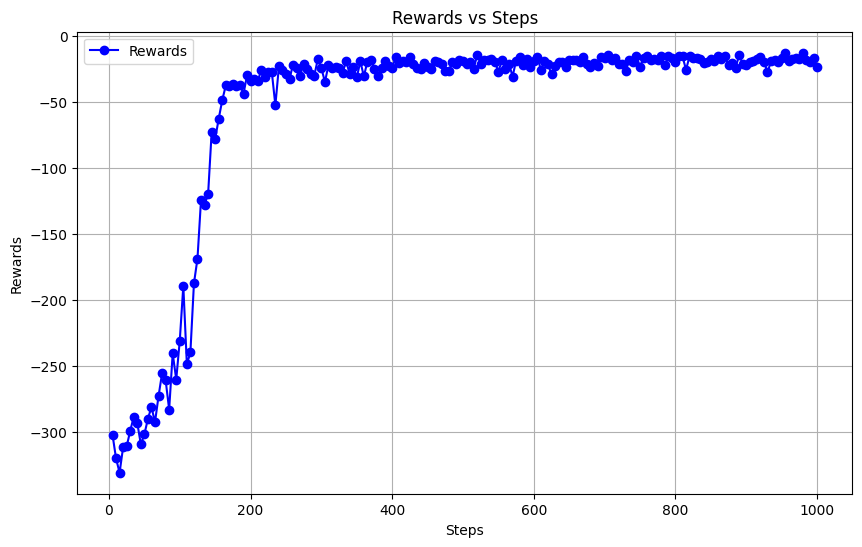

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the trainer_stats.json file
with open('outputs/checkpoint-1000/trainer_state.json', 'r') as f:
    trainer_state = json.load(f)

# Extract the log history which contains the training information
log_history = trainer_state['log_history']

# Extract steps and rewards
steps = [log["step"] for log in log_history]
rewards = [log["reward"] for log in log_history]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, rewards, label='Rewards', color='blue', marker='o')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Rewards')
plt.title('Rewards vs Steps')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

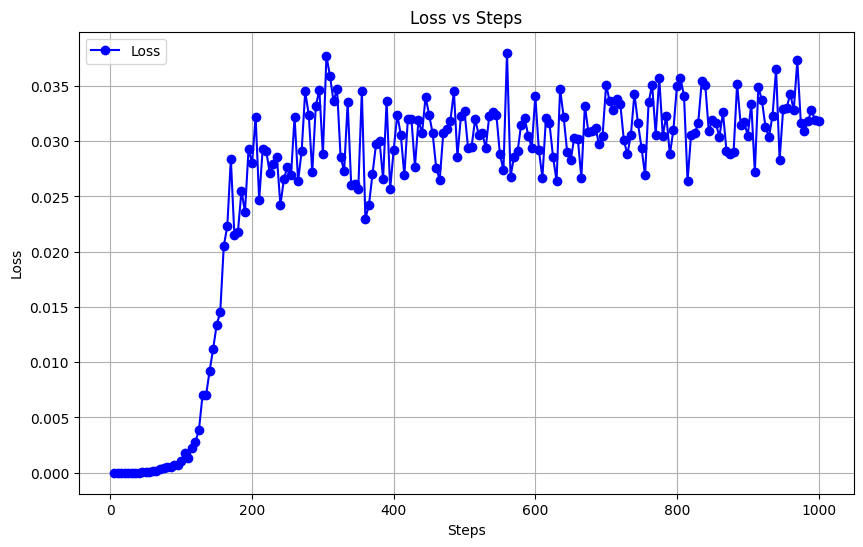

In [ ]:

# Extract steps and loss
steps = [log["step"] for log in log_history]
loss = [log["loss"] for log in log_history]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, loss, label='Loss', color='blue', marker='o')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss vs Steps')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

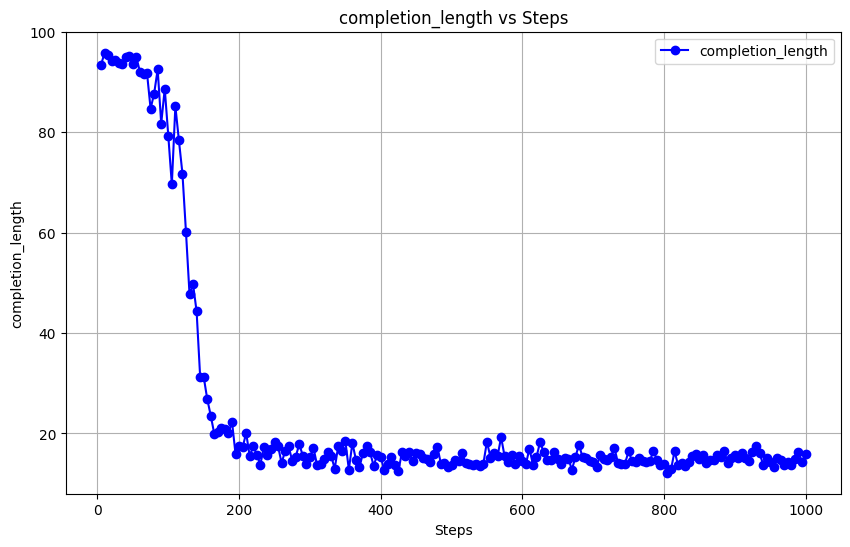

In [ ]:

# Extract steps and loss
steps = [log["step"] for log in log_history]
completion_length = [log["completion_length"] for log in log_history]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, completion_lengths, label='completion_length', color='blue', marker='o')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('completion_length')
plt.title('completion_length vs Steps')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

#output from the trained model

In [ ]:

for i in range(5):

  # Define input prompt
  input_text = dataset['train'][i]['prompt']
  # Convert input text into input format for the model, load it on GPU
  inputs = tokenizer(input_text, return_tensors="pt").to("cuda")  # Ensure the model and tensors are on the GPU


  # Generate output tokens
  output_tokens = model.generate(**inputs, max_length=500)  # Adjust max_length as needed

  # Slice to get only the generated tokens (excluding input tokens)
  generated_tokens = output_tokens[0][inputs['input_ids'].shape[1]:]  # Remove input tokens

  # Decode only the generated tokens
  output_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

  # Print the generated response
  print(f"------------ response to {i+1} prompt------------ ")
  print(output_text)



------------ response to 1 prompt------------ 
 I'm still trying to get my dog to pet me!
------------ response to 2 prompt------------ 
 Is it possible to help me with this problem?
------------ response to 3 prompt------------ 
 I'm still unhappy with my life after 30.
------------ response to 4 prompt------------ 
 I'm going to quit my job and I'm not sure what to do.
------------ response to 5 prompt------------ 
 I'm still unsure how to support my friend.


# Save and publish the model

In [ ]:
from huggingface_hub import login

# Log in to Hugging Face Hub
login()

In [ ]:
# Save to 16-bit precision
model.save_pretrained_merged("model", tokenizer, save_method="merged_16bit")

Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 115.3M


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 1.89 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 30/30 [00:00<00:00, 103.29it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model/pytorch_model.bin...
Done.


In [ ]:
# Push to Hugging Face Hub (requires a token)
model.push_to_hub_merged(
    "abdulsamad/SmolGRPO-135M", tokenizer, save_method="merged_16bit"
)

Unsloth: You are pushing to hub, but you passed your HF username = abdulsamad.
We shall truncate abdulsamad/SmolGRPO-135M to SmolGRPO-135M


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 1.86 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 30/30 [00:00<00:00, 144.32it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving SmolGRPO-135M/pytorch_model.bin...


README.md:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/abdulsamad/SmolGRPO-135M


In [6]:
from google.colab import _message

def fully_clean_widgets():
    # Get current notebook
    notebook_json = _message.blocking_request('get_ipynb', {})

    # --- Clean notebook-level metadata ---
    if 'widgets' in notebook_json.get('metadata', {}):
        print("Removing notebook-level 'widgets' metadata...")
        del notebook_json['metadata']['widgets']

    # --- Clean cell-level metadata ---
    cleaned_cells = 0
    for cell in notebook_json.get('cells', []):
        if 'metadata' in cell and 'widgets' in cell['metadata']:
            del cell['metadata']['widgets']
            cleaned_cells += 1

    print(f"Removed 'widgets' metadata from {cleaned_cells} cells.")

    # Save back cleaned notebook
    _message.blocking_request('set_ipynb', notebook_json)
    print("Notebook cleaned successfully!")

fully_clean_widgets()


Removed 'widgets' metadata from 0 cells.
Notebook cleaned successfully!
